In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
# service = QiskitRuntimeService(channel="ibm_quantum")
service = QiskitRuntimeService.save_account(channel="ibm_quantum", overwrite=True, token="6e8e73f18c3c1bc4217e22bce7d03e39f64ba95164994c3356f8c6188d2eabc66e0062fadd5c039cd1bc4d9c6f803b2b964961bf126cc0df315929969555b5e8")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [2]:
#Useful imports: 
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import Operator
from qiskit import *
import numpy as np
from qiskit import QuantumCircuit, execute, BasicAer
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.opflow import I, Z, X

import matplotlib.pyplot as plt
%matplotlib inline

/var/folders/07/9l9kqd013xjdlz8_0b2__8xr0000gq/T/ipykernel_41662/1227636932.py:9: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import I, Z, X


 ## 3.1 Generate a random unitary U by generating a random circuit over $n=5$ qubits with depth$=3$
 You may use Qiskit's built-in function for random circuits: https://qiskit.org/documentation/stable/0.19/stubs/qiskit.circuit.random.random_circuit.html. 
 Visualize your random circuit using **draw(output='mpl')**.

/opt/homebrew/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


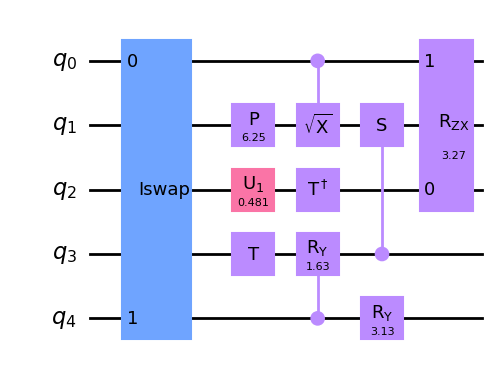

In [3]:
# your code goes here
circ = random_circuit(5, 3, measure=False)
my_gate = circ.to_gate()
controlled_x = my_gate.control()
circ.draw(output='mpl')

## 3.2 Compute the trace of the generated random unitary classically. 
For a circuit U, you may use **Operator(U).data** to convert U into a numpy array.

In [4]:
trace = np.trace(Operator(circ).data)
print("trace: ", trace)
print("real part: ", trace.real)

trace:  (-0.2753542770791947-0.2900336230759865j)
real part:  -0.2753542770791947


## 3.3 Build the circuit for estimating the real part of the trace of U. 
Hint: you may find the following useful: 
**.to_gate()** : https://qiskit.org/documentation/stable/0.39/stubs/qiskit.circuit.QuantumCircuit.to_gate.html

**.control(..)**: https://qiskit.org/documentation/stubs/qiskit.circuit.ControlledGate.html

**.append(..)**: https://qiskit.org/documentation/stable/0.19/stubs/qiskit.circuit.QuantumCircuit.append.html

In [31]:
# create entangled pairs
X = QuantumRegister(1, 'x')
X1 = QuantumRegister(2, 'x1')
X2 = QuantumRegister(2, 'x2')
X3 = QuantumRegister(2, 'x3')
X4 = QuantumRegister(2, 'x4')
X5 = QuantumRegister(2, 'x5')

A = ClassicalRegister(1, 'a')

circuit = QuantumCircuit(X, X1, X2, X3, X4, X5, A)

# add state vector |0> to X
circuit.reset(X)
circuit.reset(X1)
circuit.reset(X2)
circuit.reset(X3)
circuit.reset(X4)
circuit.reset(X5)
circuit.barrier()


circuit.h(X1[0])
circuit.cx(X1[0], X1[1])

circuit.h(X2[0])
circuit.cx(X2[0], X2[1])

circuit.h(X3[0])
circuit.cx(X3[0], X3[1])

circuit.h(X4[0])
circuit.cx(X4[0], X4[1])

circuit.h(X5[0])
circuit.cx(X5[0], X5[1])

circuit.barrier()
circuit.h(X)

circuit.append(controlled_x, [X[0], X1[0], X2[0], X3[0], X4[0], X5[0]])

circuit.h(X)

# circuit.measure(X, A)
circuit.barrier()

circuit.measure(X[0], A)

#### Draw your estimation circuit: 

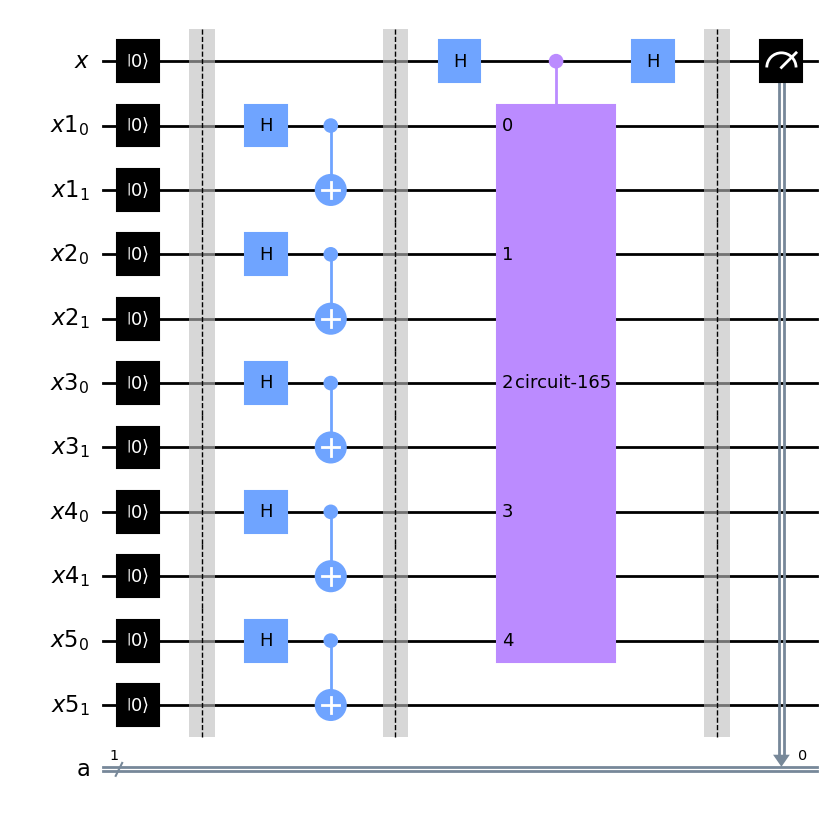

In [8]:
circuit.draw(output='mpl')

#### Run your circuit using the 'qasm_simulator'.
Compute the estimate of the trace of the real part from the circuit results.
Compare your estimate with the one computed in question 3.2.
You may change the number of shots till you obtain an accurate result.

In [27]:
simulator = Aer.get_backend('qasm_simulator')
nb_shots = 100000
result = execute(circuit, simulator, shots=nb_shots).result()
counts = result.get_counts(circuit)
counts

{'1': 50390, '0': 49610}

In [28]:
real_part_trace = (counts['0']/nb_shots- 0.5) * 2**6
print("quantum real part of trace: ", real_part_trace)
print("np trace real: ",  trace.real)

quantum real part of trace:  -0.24960000000000093
np trace real:  -0.2753542770791947


## 4.1 Generate the unitary $U_{\text{mystery}} = e^{i\theta (X\otimes X)}$ for $\theta = \pi/3$.
Hint: use https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliEvolutionGate.html 

In [52]:
theta = np.pi / 3
X = np.array([[0, 1], [1, 0]])

U_mystery = np.cos(theta) * np.eye(4) + 1j * np.sin(theta) * np.kron(X, X)

## 4.2 Vary $\theta$ from 0 to $\pi/2$. For each value, generate the estimation circuit for the real part of the trace of $U_{\text{mystery}}$.
Run your circuit using the Qiskit simulator. Make a plot: on the x-axis: $\theta$ from 0 to $\pi/2$, and on the y-axis: your obtained estimate for $\theta$ . 

In [36]:
def create_gate(theta):
    X = np.array([[0, 1], [1, 0]])  # Pauli-X gate

    U_mystery = np.cos(theta) * np.eye(4) + 1j * np.sin(theta) * np.kron(X, X)

    qc = QuantumCircuit(2)

    qc.unitary(U_mystery, [0, 1])

    my_gate = qc.to_gate()
    controlled_U = my_gate.control()
    return controlled_U

In [37]:
def simulate_circuit(circuit, nb_shots):
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuit, simulator, shots=nb_shots).result()
    counts = result.get_counts(circuit)
    return counts

In [54]:
from numpy import pi, arccos

def compute_theta(counts, angle):
    count_0 = counts.get('0', 0)
    
    real_part_trace = (count_0/nb_shots- 0.5) * 2**3
    
    if angle < pi:
        return arccos(real_part_trace/4)
    else:
        return 2*pi - arccos(real_part_trace/4)

In [55]:
def compute_theta_estimates(angles, nb_shots):
    estimates_theta = []
    reals_theta = []
    
    for angle in angles:
        controlled_U = create_gate(angle)
        
        # create entangled pairs
        X = QuantumRegister(1, 'x')
        X1 = QuantumRegister(2, 'x1')
        X2 = QuantumRegister(2, 'x2')

        A = ClassicalRegister(1, 'a')

        circuit = QuantumCircuit(X, X1, X2, A)

        # add state vector |0> to X
        circuit.reset(X)
        circuit.reset(X1)
        circuit.reset(X2)
        circuit.barrier()


        circuit.h(X1[0])
        circuit.cx(X1[0], X1[1])

        circuit.h(X2[0])
        circuit.cx(X2[0], X2[1])

        circuit.barrier()
        circuit.h(X)

        circuit.append(controlled_U, [X[0], X1[0], X2[0]])

        circuit.h(X)

        # circuit.measure(X, A)
        circuit.barrier()
        circuit.measure(X, A)

        reals_theta.append(angle)
        counts = simulate_circuit(circuit, nb_shots)
        theta = compute_theta(counts, angle)
        estimates_theta.append(theta)
    
    return reals_theta, estimates_theta
    

In [44]:
nb_shots = 1000

/opt/homebrew/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


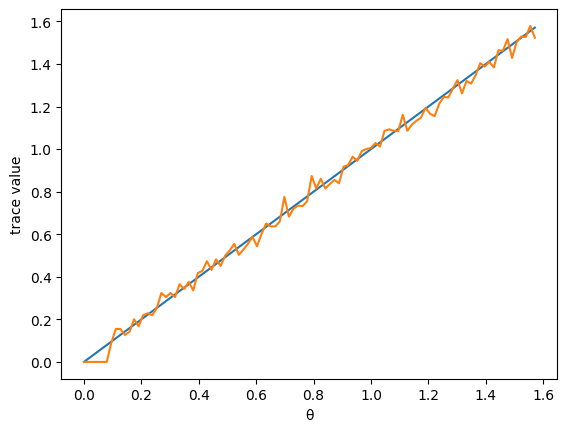

In [56]:
# for theta between 0 and pi/2
angles = np.linspace(0, np.pi/2, 100)
reals_theta, estimates_theta = compute_theta_estimates(angles, nb_shots)

import matplotlib.pyplot as plt
plt.plot(angles, reals_theta)
plt.plot(angles, estimates_theta)
plt.xlabel("θ")
plt.ylabel("trace value")
plt.show()

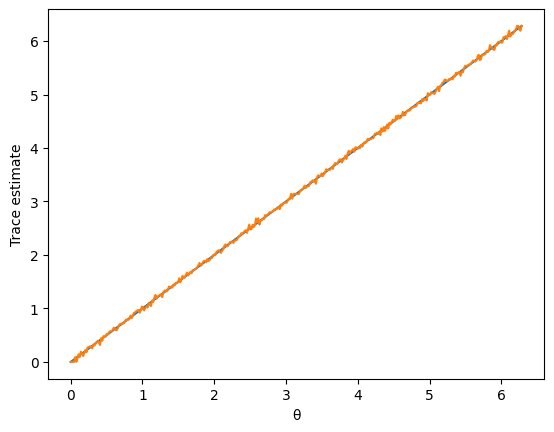

In [57]:
# for theta between 0 and 2pi (to answer the question from the PDF)
angles = np.linspace(0,2*pi, 400)
reals_theta, estimates_theta = compute_theta_estimates(angles, nb_shots)

import matplotlib.pyplot as plt
plt.plot(angles, reals_theta)
plt.plot(angles, estimates_theta)
plt.xlabel("θ")
plt.ylabel("Trace estimate")
plt.show()

## 5.3 Take the circuit generated in 3.1. For different values of $k$, run the trace estimation circuit $k$ number of shots and compute 1) the single value estimate of the real part of the trace of U and 2) the CI you got in the exercise 5.2 at level $95\%$



In [40]:
# your code goes here

## Plot the true real part of the trace, the single-value estimate of it, and the CI against $k$. 

For drawing CIs, you can use https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html

In [41]:
# your code goes here